# New York City Taxi Fare Prediction

## Признаки
* **pickup_datetime** - время начала поездки
* **pickup_longitude** - координата долготы начала поездки
* **pickup_latitude** - координата широты начала поездки
* **dropoff_longitude** - координата долготы конца поездки
* **dropoff_latitude** - координата широты конца поездки
* **passenger_count** - число пассажиров

## Целевой признак
* **fare_amount** - стоимость поездки

In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm 
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from math import sqrt
from scipy.spatial import distance

%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('train.csv', nrows=1000)

In [3]:
df.shape

(1000, 8)

In [4]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Предобработка
### Время
* Парсинг времени
* Создание признака - расстояние между точками

In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday.map({0 : 'Monday', 1: 'Tuesday', 2: 'Wednesday',
                                                     3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

In [6]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,Monday
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,Tuesday
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,Thursday
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,Saturday
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,Tuesday
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,9,Thursday
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,Tuesday
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,17,Wednesday
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,13,Monday
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,1,Wednesday


In [7]:
df['manhattan_distance'] = df.apply(lambda x: 
    distance.cityblock([x['pickup_longitude'], x['pickup_latitude']], [x['dropoff_longitude'], x['dropoff_latitude']]), axis=1)

In [8]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,manhattan_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,Monday,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,Tuesday,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,Thursday,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,Saturday,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,Tuesday,0.027194


In [9]:
df[df.isna().any(axis=1)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,manhattan_distance


In [10]:
df.drop(['key','pickup_datetime'], axis=1, inplace=True)

### Графики распределения величин

Уберем выбросы, чтобы можно было смотреть на графики

In [11]:
tmp = df['weekday']
df.drop('weekday', axis=1, inplace=True)

In [12]:
df = df[(np.abs(scipy.stats.zscore(df)) < 3).all(axis=1)]

In [13]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,manhattan_distance
0,4.50,-73.844311,40.721319,-73.841610,40.712278,1,17,0.011742
1,16.90,-74.016048,40.711303,-73.979268,40.782004,1,16,0.107481
2,5.70,-73.982738,40.761270,-73.991242,40.750562,2,0,0.019212
3,7.70,-73.987130,40.733143,-73.991567,40.758092,1,4,0.029386
4,5.30,-73.968095,40.768008,-73.956655,40.783762,1,7,0.027194
5,12.10,-74.000964,40.731630,-73.972892,40.758233,1,9,0.054675
6,7.50,-73.980002,40.751662,-73.973802,40.764842,1,20,0.019380
7,16.50,-73.951300,40.774138,-73.990095,40.751048,1,17,0.061885
8,9.00,-74.006462,40.726713,-73.993078,40.731628,1,13,0.018299
9,8.90,-73.980658,40.733873,-73.991540,40.758138,2,1,0.035147


In [14]:
df = pd.concat([df, tmp], axis=1, join='inner')

In [15]:
df = df.reset_index(drop=True)

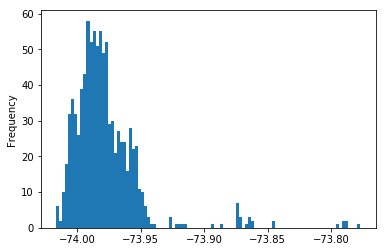

In [16]:
df['pickup_longitude'].plot.hist(bins=100)

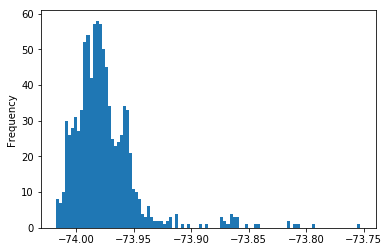

In [17]:
df['dropoff_longitude'].plot.hist(bins=100)

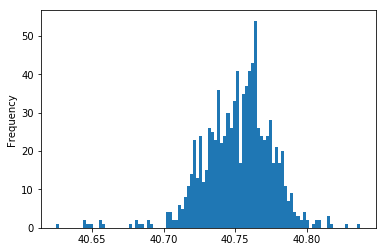

In [18]:
df['pickup_latitude'].plot.hist(bins=100)

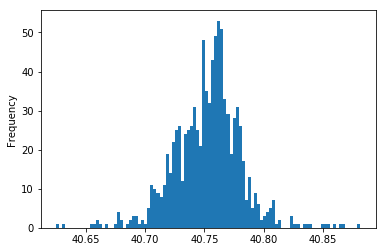

In [19]:
df['dropoff_latitude'].plot.hist(bins=100)

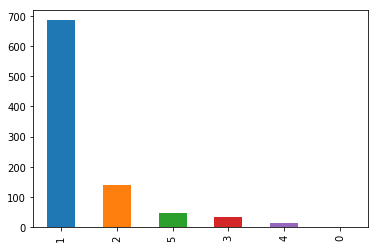

In [20]:
df['passenger_count'].value_counts().plot(kind='bar')

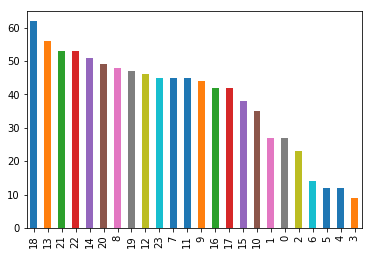

In [21]:
df['hour'].value_counts().plot(kind='bar')

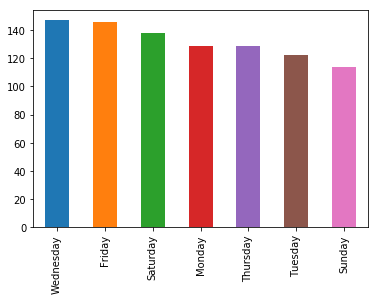

In [22]:
df['weekday'].value_counts().plot(kind='bar')

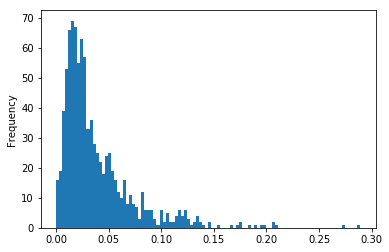

In [23]:
df['manhattan_distance'].plot.hist(bins=100)

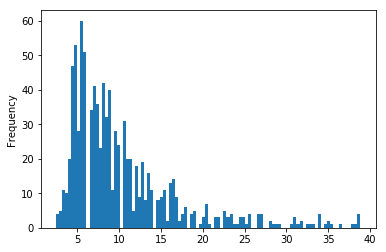

In [24]:
df['fare_amount'].plot.hist(bins=100)

Видим, что целевая переменная имеет достаточно большой разброс (не в пределах [0,5], например). Это знание нам поможет при выборе целевой метрики

---

#### Построим корреляционную матрицу, не забыв о том, что hour и weekday имеют категориальную природу - эти дискретные величины имеют много значений и одно значение не даст яркую корреляцию с таргетом - а картинку загрязнит, поэтому их не включаем

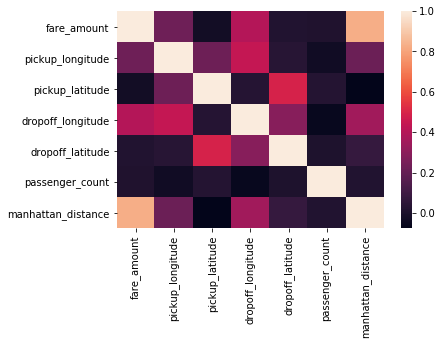

In [25]:
sns.heatmap(df.drop(['hour', 'weekday'], axis=1).corr())

In [26]:
df = pd.concat([df,pd.get_dummies(df['hour'])], axis=1)
df = pd.concat([df,pd.get_dummies(df['weekday'])], axis=1)
df.drop(['hour', 'weekday'], axis=1, inplace=True)

### Можно применить машинное обучение для аппроксимации зависимости fare_amount от набора остальных входных признаков

#### Выбраны метрики:
* 1 - R2 метрика. Самый лучший выбор в задачи регрессии, когда мы не знаем какой результат есть хорошо, а какой плохо (в хакатонах можно сразу брать mse, там понятно что хорошо, а что плохо)
* 2 - MAE - среднее модульное отклонение
* 3 - RMSE - с.к.о., сильно бьет за большие ошибки и мало бьет за маленькие [0;1]

#### Выбраны модели:
* 1 - Линейная регрессия - показать результат самой примитивной по работе модель
* 2 - Random Forest Regressor - ансамблевая модель
* 2 - LightGBM - ансамблевая модель, дает лучшие показатели, на ней будет запущена кроссвалидация по сетке гиперпараметров

#### Будет запущен каждый эксперимент по отдельности, после каждого прогона я логаю информацию в MLFlow, тут будут данные только последнего эксперимента, в репозитории будет предоставлен скриншот

In [36]:
lightgbm_parameters = {
            'subsample':[0.6, 1],
            'colsample_bytree': [0.8, 1],
            'n_estimators':[100, 300, 400],
            'n_jobs':[-1],
            'silent':[True],
            'verbosity':[0]
}

In [77]:
random_search = GridSearchCV(estimator= lightgbm.LGBMRegressor(),
                             param_grid= lightgbm_parameters,
                             scoring= 'neg_mean_squared_error', 
                             cv= 3)

random_search.fit(df.loc[:, df.columns != 'fare_amount'], df['fare_amount'])

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'subsample': [0.6, 1], 'colsample_bytree': [0.8, 1], 'n_estimators': [100, 300, 400], 'n_jobs': [-1], 'silent': [True], 'verbosity': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [78]:
random_search.best_params_

{'colsample_bytree': 1,
 'n_estimators': 100,
 'n_jobs': -1,
 'silent': True,
 'subsample': 0.6,
 'verbosity': 0}

In [61]:
# r2 = random_search.best_score_

# mae = -random_search.best_score_

# rmse = sqrt(-random_search.best_score_)

# r2, mae, rmse

In [67]:
import mlflow

In [80]:
with mlflow.start_run(run_name='second_good_model'):

    mlflow.log_param('model_name', 'LGBMRegressor')
    mlflow.log_param('parameters', random_search.best_params_)
    
    mlflow.log_metric('rmse', sqrt(-random_search.best_score_))